In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import joblib
import numpy as np
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import regionmask
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def compare_flood_models(
    data_path,
    model_base_path,
    month_str,
    start_day,
    end_day,
    model_types=None,
    feature_extractor=None,
    predictor=None
):


    if model_types is None:
        model_types = ["xgb", "rf", "svm", "lr", "dt", "gb", "ada", "mlp"]

    if feature_extractor is None or predictor is None:
        raise ValueError("You must pass feature_extractor and predictor functions.")


    model_predictions = {}
    for model_name in model_types:
        model_file = os.path.join(model_base_path, f"flood_model_mandi_{model_name}.pkl")
        scaler_file = os.path.join(model_base_path, f"flood_model_mandi_scaler.pkl")

        if not os.path.exists(model_file):
            print(f"⚠️ Skipping {model_name}: model file not found.")
            continue

        print(f"🔮 Running predictions for model: {model_name.upper()}")

        preds = []
        dates = []

        for day in range(start_day, end_day + 1):
            date_str = f"{month_str}-{day:02d} 00:00:00"
            features = feature_extractor(data_path, date_str)
            prob = predictor(model_file, scaler_file, features)
            preds.append(prob)
            dates.append(pd.to_datetime(date_str))

        model_predictions[model_name] = pd.Series(preds, index=dates)


    plt.figure(figsize=(12, 6))
    for name, preds in model_predictions.items():
        plt.plot(preds.index, preds.values, label=name.upper())

    plt.title(f"Flood Probability Predictions — {month_str}")
    plt.xlabel("Date")
    plt.ylabel("Flood Probability")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Models")
    plt.tight_layout()
    plt.show()


    n_models = len(model_predictions)
    if n_models == 0:
        print("❌ No models available to plot.")
        return model_predictions

    fig, axes = plt.subplots(n_models, 1, figsize=(12, 3 * n_models), sharex=True)
    if n_models == 1:
        axes = [axes]

    for ax, (name, preds) in zip(axes, model_predictions.items()):
        ax.plot(preds.index, preds.values, marker="o", label=name.upper())
        ax.set_title(f"{name.upper()} Flood Probability")
        ax.set_ylabel("Probability")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend()

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()

    return model_predictions

def predict_flood_probability(model_path, scaler_path, input_features):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    x = np.array(input_features).reshape(1, -1)
    x_scaled = scaler.transform(x)
    return float(model.predict_proba(x_scaled)[0, 1])


In [ ]:
def extract_Kinnaur_features_from_nc(nc_path, date_time):

    ds = xr.open_dataset(nc_path)
    if "valid_time" in ds.dims:
        ds = ds.rename({"valid_time": "time"})


    hp_shp = gpd.read_file("/Users/mayankgoel/Desktop/Stat/Stat_project/gadm41_IND_2.shp")
    hp_shp = hp_shp[hp_shp["NAME_1"] == "Himachal Pradesh"].to_crs(4326)
    hp_shp = hp_shp.dissolve(by="NAME_2").reset_index()

    districts = regionmask.Regions(
        outlines=hp_shp.geometry.values,
        names=hp_shp["NAME_2"].values,
        abbrevs=hp_shp["NAME_2"].values
    )

    mask = districts.mask(ds.longitude, ds.latitude)
    district_num = np.where(np.array(districts.names) == "Kinnaur")[0][0]
    district_mask = (mask == district_num)


    lon_2d, lat_2d = np.meshgrid(ds.longitude, ds.latitude)
    weights_2d = np.cos(np.deg2rad(lat_2d))
    weights_xr = xr.DataArray(
        weights_2d,
        coords={'latitude': ds.latitude, 'longitude': ds.longitude},
        dims=['latitude', 'longitude']
    )


    target_time = pd.to_datetime(date_time)
    if target_time not in pd.to_datetime(ds.time.values):
        print(f"⚠️ Date/time {target_time} not found in file {nc_path}")
        return None

    ds_sel = ds.sel(time=target_time)


    ds_masked = ds_sel.where(district_mask)
    weighted_sum = (ds_masked * weights_xr).sum(dim=["latitude", "longitude"])
    total_weight = weights_xr.where(district_mask).sum(dim=["latitude", "longitude"])
    weighted_avg = weighted_sum / total_weight


    features = ["d2m", "t2m", "swvl1", "swvl2", "swvl3", "ssro", "sro", "tp"]
    values = [float(weighted_avg[var].values) for var in features if var in weighted_avg]

    if len(values) != 8:
        print("⚠️ Missing variables in dataset; found:", len(values))
        return None
    return values

features = extract_Kinnaur_features_from_nc("/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_09_daily.nc", "2025-09-29 00:00:00")

🔮 Running predictions for model: XGB
🔮 Running predictions for model: RF
🔮 Running predictions for model: SVM
🔮 Running predictions for model: LR
⚠️ Skipping dt: model file not found.
⚠️ Skipping gb: model file not found.
⚠️ Skipping ada: model file not found.
🔮 Running predictions for model: MLP


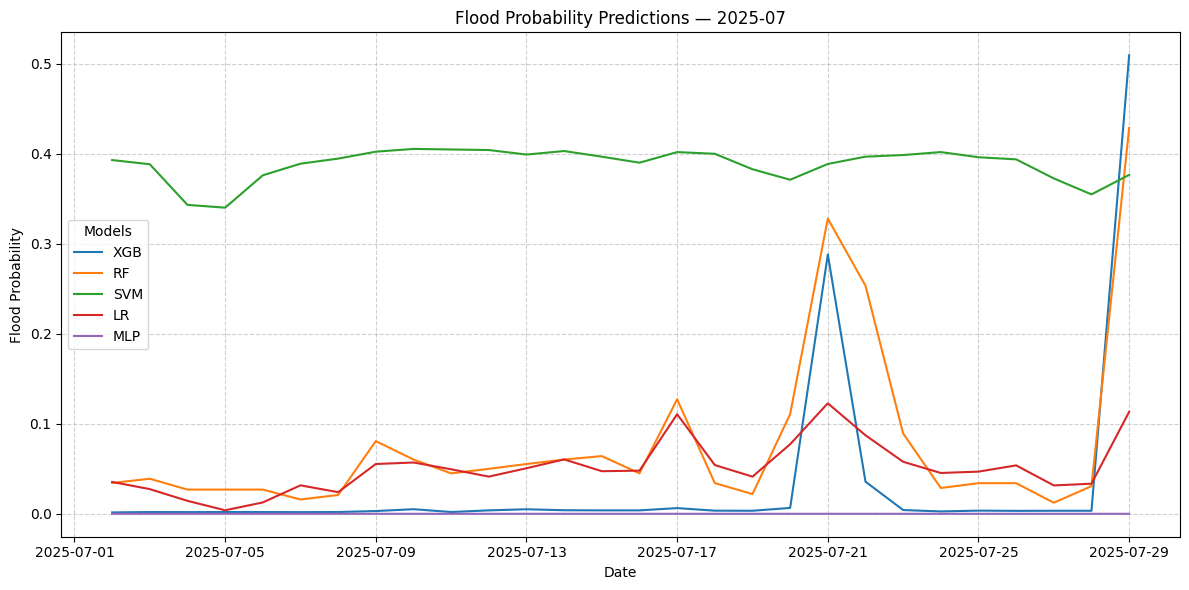

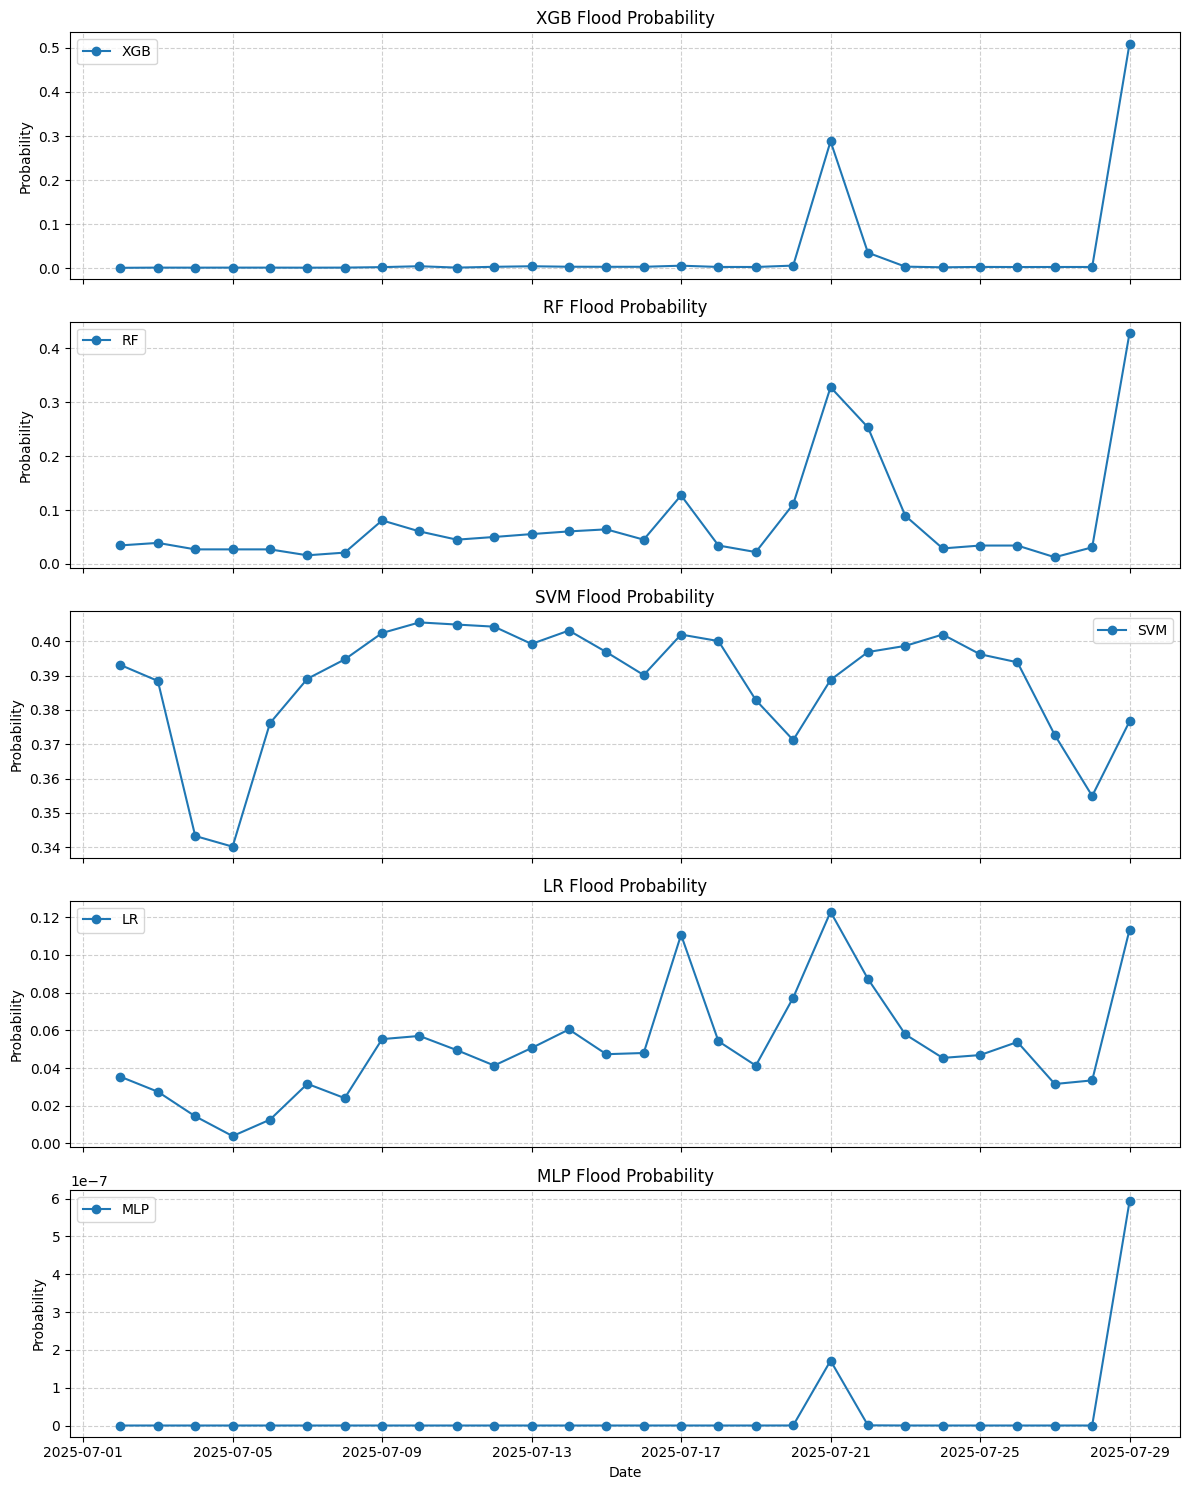

In [3]:
model_predictions = compare_flood_models(
    data_path="/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_07_daily.nc",
    model_base_path="/Users/mayankgoel/Desktop/Stat/Model_district",
    month_str="2025-07",
    start_day=2,
    end_day=29,
    feature_extractor=extract_Kinnaur_features_from_nc,
    predictor=predict_flood_probability
)


🔮 Running predictions for model: XGB
🔮 Running predictions for model: RF
🔮 Running predictions for model: SVM
🔮 Running predictions for model: LR
⚠️ Skipping dt: model file not found.
⚠️ Skipping gb: model file not found.
⚠️ Skipping ada: model file not found.
🔮 Running predictions for model: MLP


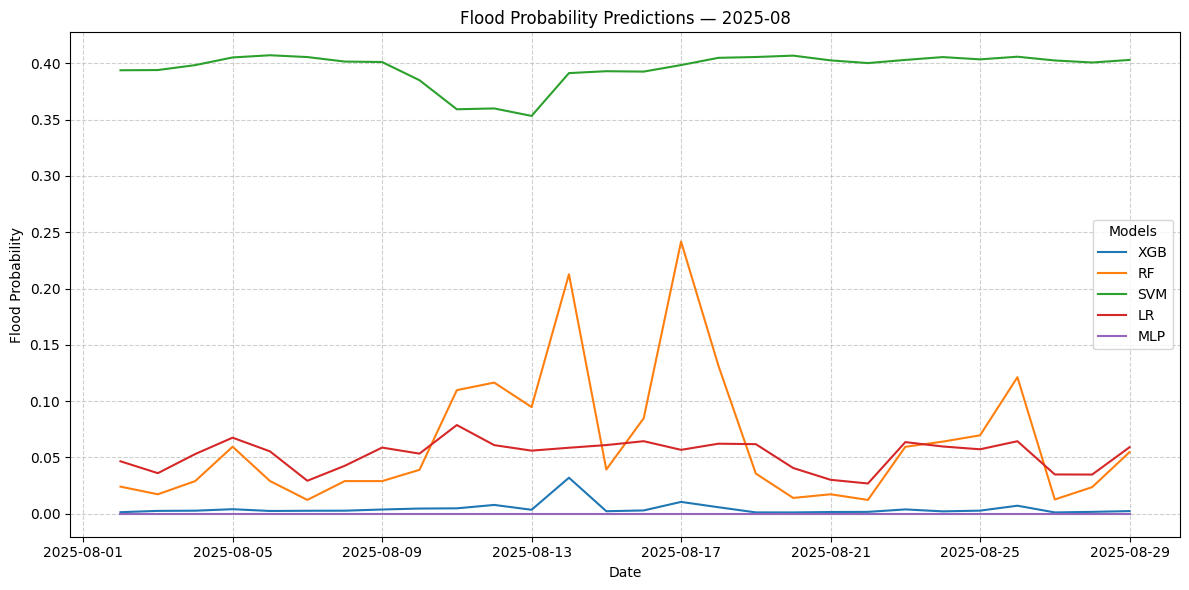

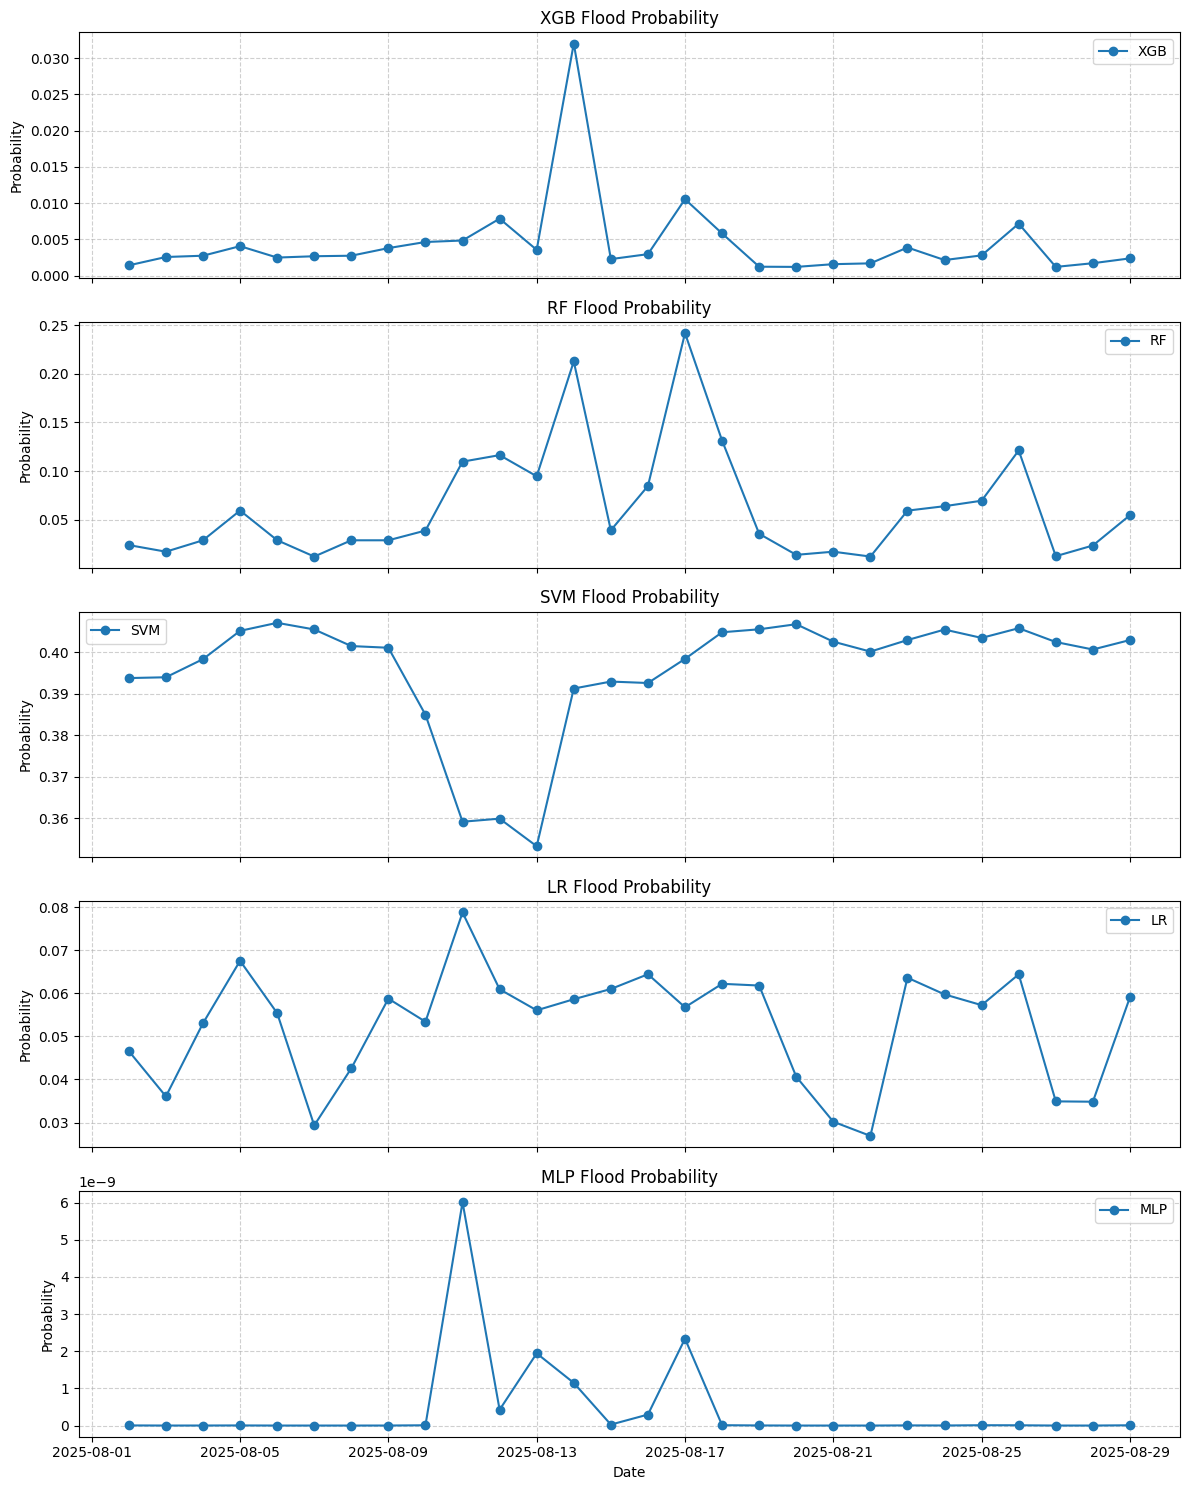

In [4]:
model_predictions = compare_flood_models(
    data_path="/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_08_daily.nc",
    model_base_path="/Users/mayankgoel/Desktop/Stat/Model_district",
    month_str="2025-08",
    start_day=2,
    end_day=29,
    feature_extractor=extract_Kinnaur_features_from_nc,
    predictor=predict_flood_probability
)


🔮 Running predictions for model: XGB
🔮 Running predictions for model: RF
🔮 Running predictions for model: SVM
🔮 Running predictions for model: LR
⚠️ Skipping dt: model file not found.
⚠️ Skipping gb: model file not found.
⚠️ Skipping ada: model file not found.
🔮 Running predictions for model: MLP


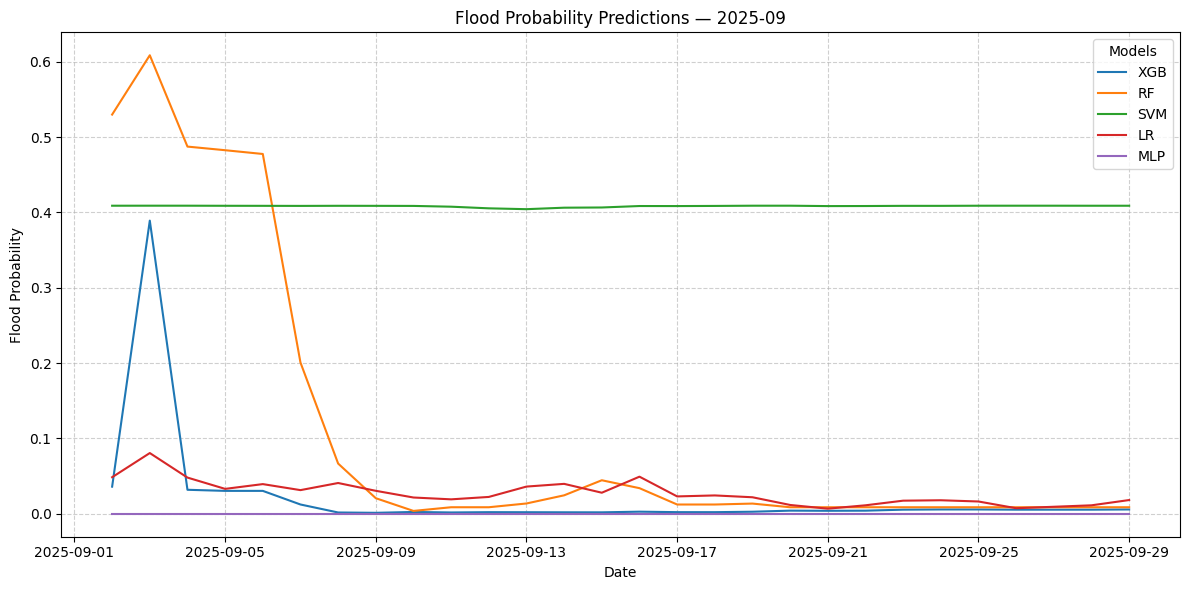

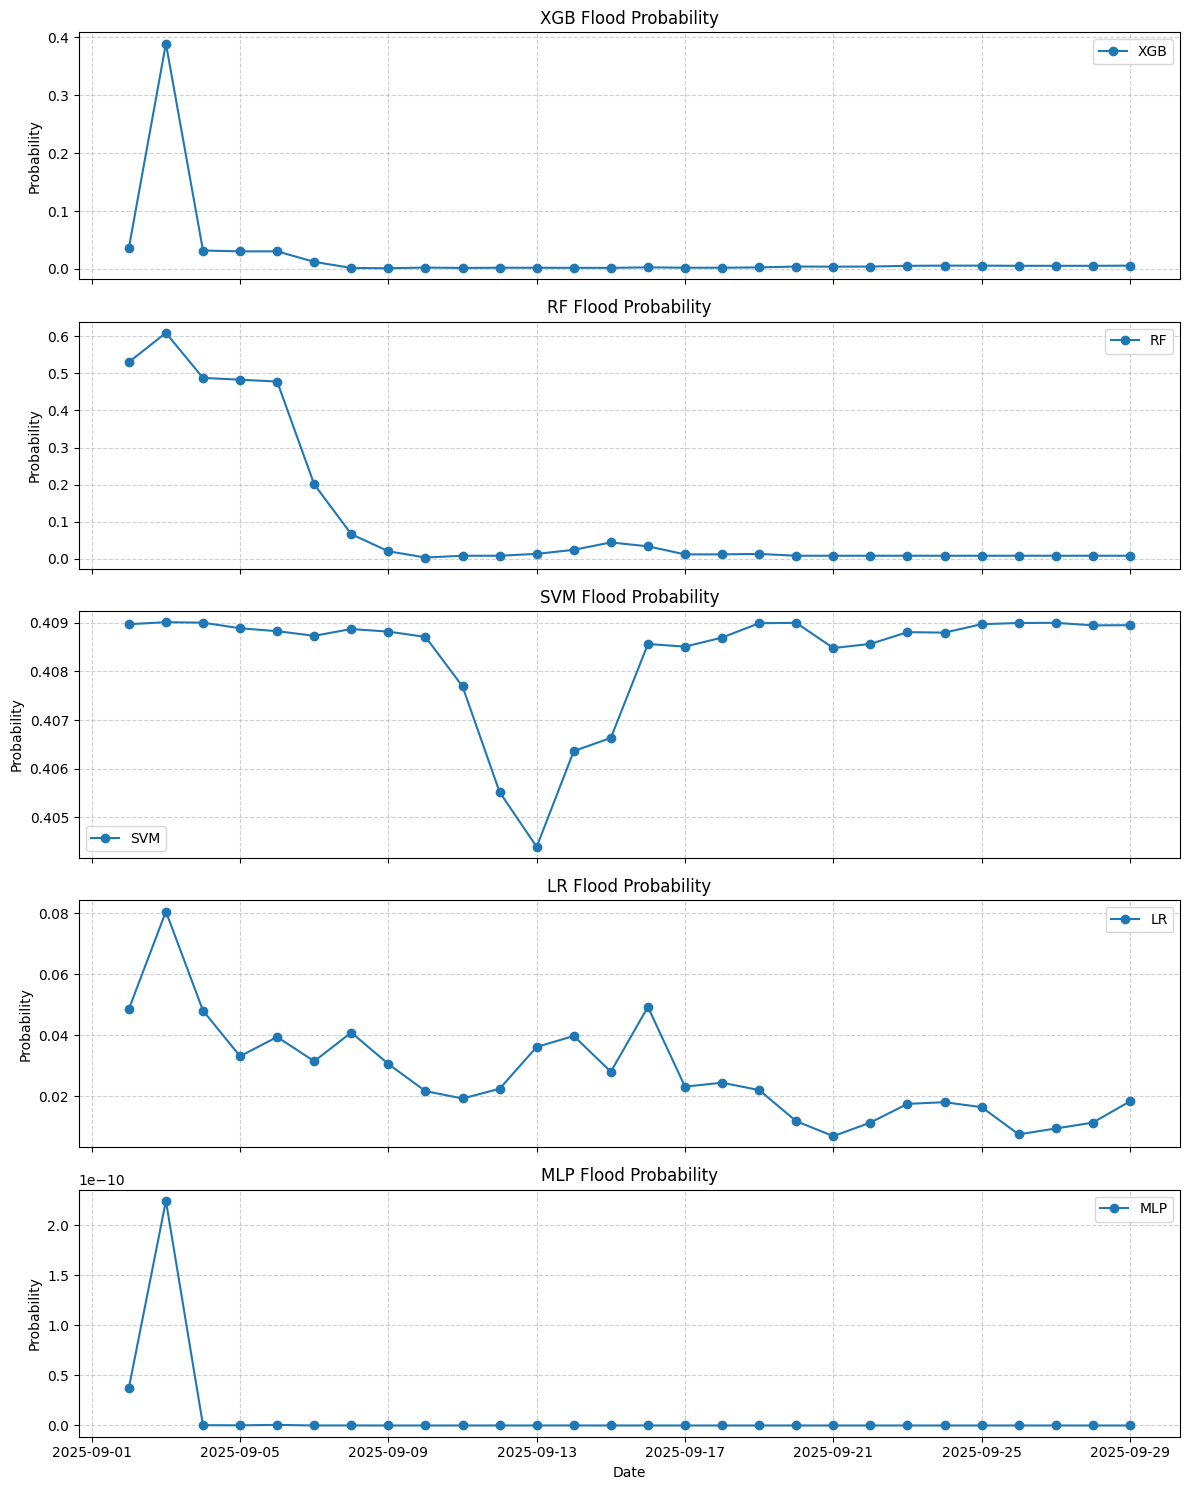

In [5]:
model_predictions = compare_flood_models(
    data_path="/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_09_daily.nc",
    model_base_path="/Users/mayankgoel/Desktop/Stat/Model_district",
    month_str="2025-09",
    start_day=2,
    end_day=29,
    feature_extractor=extract_Kinnaur_features_from_nc,
    predictor=predict_flood_probability
)


🔮 Running flood probability predictions for Kinnaur — RF


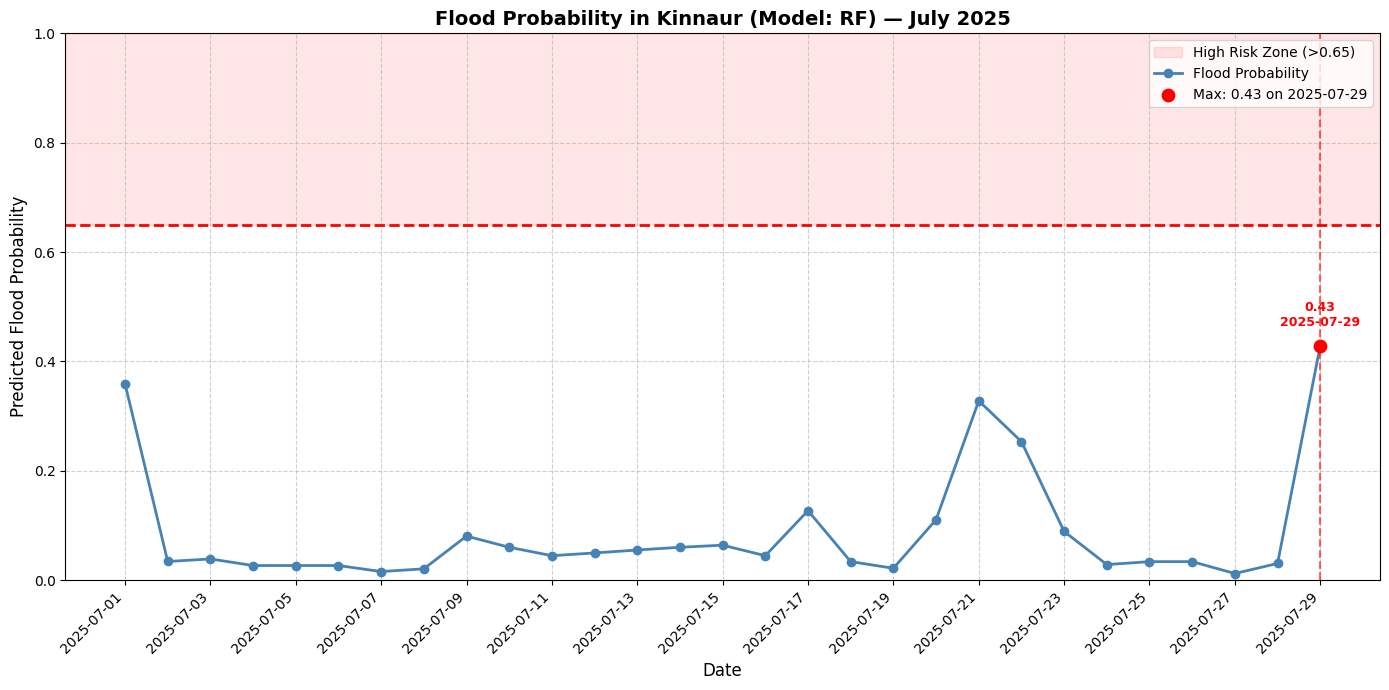

2025-07-01    0.359230
2025-07-02    0.034294
2025-07-03    0.038937
2025-07-04    0.026903
2025-07-05    0.026903
2025-07-06    0.026903
2025-07-07    0.015903
2025-07-08    0.020903
2025-07-09    0.080751
2025-07-10    0.060294
2025-07-11    0.044937
2025-07-12    0.049937
2025-07-13    0.055294
2025-07-14    0.060294
2025-07-15    0.064103
2025-07-16    0.044937
2025-07-17    0.127217
2025-07-18    0.034103
2025-07-19    0.021903
2025-07-20    0.110751
2025-07-21    0.328078
2025-07-22    0.253478
2025-07-23    0.089259
2025-07-24    0.028666
2025-07-25    0.034023
2025-07-26    0.034023
2025-07-27    0.012320
2025-07-28    0.030711
2025-07-29    0.428792
dtype: float64

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_flood_probability_single_model(
    data_path,
    model_base_path,
    month_str,
    start_day,
    end_day,
    model_name,
    threshold,
    district_name,
    feature_extractor,
    predictor,
    figsize=(12, 6)   
):

    model_file = os.path.join(model_base_path, f"flood_model_mandi_{model_name}.pkl")
    scaler_file = os.path.join(model_base_path, f"flood_model_mandi_scaler.pkl")

    if not os.path.exists(model_file):
        print(f"❌ Model file not found: {model_file}")
        return
    if not os.path.exists(scaler_file):
        print(f"❌ Scaler file not found: {scaler_file}")
        return

    print(f"🔮 Running flood probability predictions for {district_name} — {model_name.upper()}")


    preds, dates = [], []
    for day in range(start_day, end_day + 1):
        date_str = f"{month_str}-{day:02d} 00:00:00"
        features = feature_extractor(data_path, date_str)
        prob = predictor(model_file, scaler_file, features)
        preds.append(prob)
        dates.append(pd.to_datetime(date_str))

    probs = pd.Series(preds, index=dates)


    plt.figure(figsize=figsize)  


    plt.axhspan(threshold, 1.0, color="red", alpha=0.1, label=f"High Risk Zone (>{threshold})")


    plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2)


    plt.plot(probs.index, probs.values, marker="o", linewidth=2, label="Flood Probability", color="steelblue")


    max_idx = probs.idxmax()
    max_val = probs.max()
    plt.scatter(max_idx, max_val, color="red", s=80, zorder=5, label=f"Max: {max_val:.2f} on {max_idx.date()}")
    plt.axvline(x=max_idx, color="red", linestyle="--", alpha=0.6)
    plt.text(
        max_idx, max_val + 0.03,
        f"{max_val:.2f}\n{max_idx.date()}",
        color="red",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )


    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45, ha="right")

    plt.title(
        f"Flood Probability in {district_name} (Model: {model_name.upper()}) — "
        f"{pd.to_datetime(month_str).strftime('%B %Y')}",
        fontsize=14,
        fontweight="bold"
    )
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Predicted Flood Probability", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(0, 1)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.show()

    return probs

plot_flood_probability_single_model(
    data_path="/Users/mayankgoel/Desktop/Stat/data_daily_sample/2025_07_daily.nc",
    model_base_path="/Users/mayankgoel/Desktop/Stat/Model_district",
    month_str="2025-07",
    start_day=1,
    end_day=29,
    model_name="rf",
    threshold=0.65,
    district_name="Kinnaur",
    feature_extractor=extract_Kinnaur_features_from_nc,
    predictor=predict_flood_probability,
    figsize=(14, 7) 
)


    RF